### Softmax regression in plain Python
Softmax regression, also called multinomial [logistic regression](https://render.githubusercontent.com/view/logistic_regression.ipynb) extends logistic regression to multiple classes.

**Given:**

* dataset $\{(\boldsymbol{x}^{(1)}, y^{(1)}), ..., (\boldsymbol{x}^{(m)}, y^{(m)})\}$
* with $\boldsymbol{x}^{(i)}$ being a $d-$dimensional vector $\boldsymbol{x}^{(i)} = (x^{(i)}_1, ..., x^{(i)}_d)$
* $y^{(i)}$ being the target variable for $\boldsymbol{x}^{(i)}$, for example with $K = 3$ classes we might have $y^{(i)} \in \{0, 1, 2\}$

A softmax regression model has the following features:

* a separate real-valued weight vector $\boldsymbol{w}= (w^{(1)}, ..., w^{(d)})$ for each class. The weight vectors are typically stored as rows in a weight matrix.
* a separate real-valued bias $b$ for each class
* the softmax function as an activation function
* the cross-entropy loss function

The training procedure of a softmax regression model has different steps. In the beginning (step 0) the model parameters are initialized. The other steps (see below) are repeated for a specified number of training iterations or until the parameters have converged.

**Step 0:** Initialize the weight matrix and bias values with zeros (or small random values).

**Step 1:** For each class $k$ compute a linear combination of the input features and the weight vector of class $k$, that is, for each training example compute a score for each class. For class $k$ and input vector $\boldsymbol{x}^{(i)}$ we have:

$score_{k}(\boldsymbol{x}^{(i)}) = \boldsymbol{w}_{k}^T \cdot \boldsymbol{x}^{(i)} + b_{k}$

where $\cdot$ is the dot product and $\boldsymbol{w}_{(k)}$ the weight vector of class $k$. We can compute the scores for all classes and training examples in parallel, using vectorization and broadcasting:

$\boldsymbol{scores} = \boldsymbol{X} \cdot \boldsymbol{W}^T + \boldsymbol{b} $

where $\boldsymbol{X}$ is a matrix of shape $(n_{samples}, n_{features})$ that holds all training examples, and $\boldsymbol{W}$ is a matrix of shape $(n_{classes}, n_{features})$ that holds the weight vector for each class.

**Step 2:** Apply the softmax activation function to transform the scores into probabilities. The probability that an input vector $\boldsymbol{x}^{(i)}$ belongs to class $k$ is given by

$\hat{p}_k(\boldsymbol{x}^{(i)}) = \frac{\exp(score_{k}(\boldsymbol{x}^{(i)}))}{\sum_{j=1}^{K} \exp(score_{j}(\boldsymbol{x}^{(i)}))}$

Again we can perform this step for all classes and training examples at once using vectorization. The class predicted by the model for $\boldsymbol{x}^{(i)}$ is then simply the class with the highest probability.

**Step 3:** Compute the cost over the whole training set. We want our model to predict a high probability for the target class and a low probability for the other classes. This can be achieved using the cross entropy loss function:

$J(\boldsymbol{W},b) = - \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^{K} \Big[ y_k^{(i)} \log(\hat{p}_k^{(i)})\Big]$

In this formula, the target labels are one-hot encoded. So $y_k^{(i)}$ is $1$ is the target class for $\boldsymbol{x}^{(i)}$ is k, otherwise $y_k^{(i)}$ is $0$.

Note: when there are only two classes, this cost function is equivalent to the cost function of [logistic regression](https://render.githubusercontent.com/view/logistic_regression.ipynb).

**Step 4:** Compute the gradient of the cost function with respect to each weight vector and bias. A detailed explanation of this derivation can be found [here](http://ufldl.stanford.edu/tutorial/supervised/SoftmaxRegression/).

The general formula for class $k$ is given by:

$ \nabla_{\boldsymbol{w}_k} J(\boldsymbol{W}, b) = \frac{1}{m}\sum_{i=1}^m\boldsymbol{x}^{(i)} \left[\hat{p}_k^{(i)}-y_k^{(i)}\right]$

For the biases, the inputs $\boldsymbol{x}^{(i)}$ will be given 1.

**Step 5:** Update the weights and biases for each class $k$:

$\boldsymbol{w}_k = \boldsymbol{w}_k - \eta \, \nabla_{\boldsymbol{w}_k} J$

$b_k = b_k - \eta \, \nabla_{b_k} J$

where $\eta$ is the learning rate.

In [3]:
from sklearn.datasets import load_iris
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
np.random.seed(13)

#### Dataset

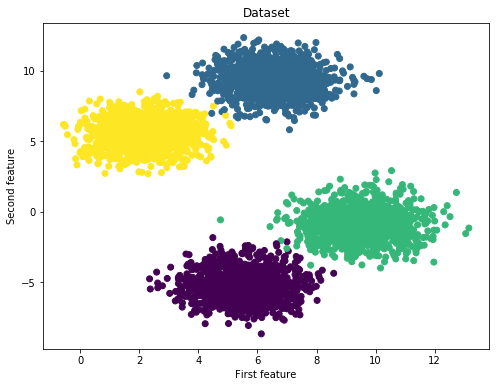

In [4]:
X, y_true = make_blobs(centers=4, n_samples = 5000)

fig = plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1], c=y_true)
plt.title("Dataset")
plt.xlabel("First feature")
plt.ylabel("Second feature")
plt.show()

In [5]:
# reshape targets to get column vector with shape (n_samples, 1)
y_true = y_true[:, np.newaxis]
# Split the data into a training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y_true)

print(f'Shape X_train: {X_train.shape}')
print(f'Shape y_train: {y_train.shape}')
print(f'Shape X_test: {X_test.shape}')
print(f'Shape y_test: {y_test.shape}')

Shape X_train: (3750, 2)
Shape y_train: (3750, 1)
Shape X_test: (1250, 2)
Shape y_test: (1250, 1)


#### Softmax regression class

In [6]:
class SoftmaxRegressor:

    def __init__(self):
        pass

    def train(self, X, y_true, n_classes, n_iters=10, learning_rate=0.1):
        """
        Trains a multinomial logistic regression model on given set of training data
        """
        self.n_samples, n_features = X.shape
        self.n_classes = n_classes
        
        self.weights = np.random.rand(self.n_classes, n_features)
        self.bias = np.zeros((1, self.n_classes))
        all_losses = []
        
        for i in range(n_iters):
            scores = self.compute_scores(X)
            probs = self.softmax(scores)
            y_predict = np.argmax(probs, axis=1)[:, np.newaxis]
            y_one_hot = self.one_hot(y_true)

            loss = self.cross_entropy(y_one_hot, probs)
            all_losses.append(loss)

            dw = (1 / self.n_samples) * np.dot(X.T, (probs - y_one_hot))
            db = (1 / self.n_samples) * np.sum(probs - y_one_hot, axis=0)

            self.weights = self.weights - learning_rate * dw.T
            self.bias = self.bias - learning_rate * db

            if i % 100 == 0:
                print(f'Iteration number: {i}, loss: {np.round(loss, 4)}')

        return self.weights, self.bias, all_losses

    def predict(self, X):
        """
        Predict class labels for samples in X.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            numpy array of shape (n_samples, 1) with predicted classes
        """
        scores = self.compute_scores(X)
        probs = self.softmax(scores)
        return np.argmax(probs, axis=1)[:, np.newaxis]

    def softmax(self, scores):
        """
        Tranforms matrix of predicted scores to matrix of probabilities
        
        Args:
            scores: numpy array of shape (n_samples, n_classes)
            with unnormalized scores
        Returns:
            softmax: numpy array of shape (n_samples, n_classes)
            with probabilities
        """
        exp = np.exp(scores)
        sum_exp = np.sum(np.exp(scores), axis=1, keepdims=True)
        softmax = exp / sum_exp
        
        return softmax

    def compute_scores(self, X):
        """
        Computes class-scores for samples in X
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            scores: numpy array of shape (n_samples, n_classes)
        """
        return np.dot(X, self.weights.T) + self.bias

    def cross_entropy(self, y_true, probs):
        loss = - (1 / self.n_samples) * np.sum(y_true * np.log(probs))
        return loss

    def one_hot(self, y):
        """
        Tranforms vector y of labels to one-hot encoded matrix
        """
        one_hot = np.zeros((self.n_samples, self.n_classes))
        one_hot[np.arange(self.n_samples), y.T] = 1
        return one_hot

#### Initializing and training the model

Iteration number: 0, loss: 3.1901
Iteration number: 100, loss: 0.2031
Iteration number: 200, loss: 0.1589
Iteration number: 300, loss: 0.1358
Iteration number: 400, loss: 0.1199
Iteration number: 500, loss: 0.1079
Iteration number: 600, loss: 0.0982
Iteration number: 700, loss: 0.0902


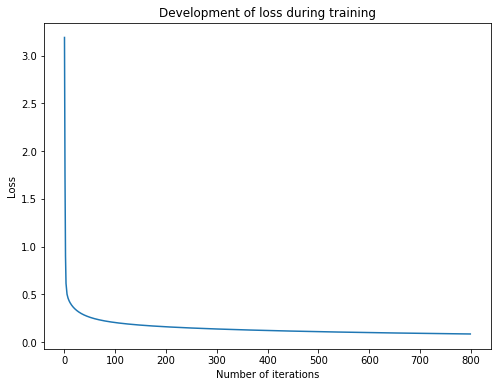

In [7]:
regressor = SoftmaxRegressor()
w_trained, b_trained, loss = regressor.train(X_train, y_train, learning_rate=0.1, n_iters=800, n_classes=4)

fig = plt.figure(figsize=(8,6))
plt.plot(np.arange(800), loss)
plt.title("Development of loss during training")
plt.xlabel("Number of iterations")
plt.ylabel("Loss")
plt.show()

In [8]:
n_test_samples, _ = X_test.shape
y_predict = regressor.predict(X_t
                              est)
print(f"Classification accuracy on test set: {(np.sum(y_predict == y_test)/n_test_samples) * 100}%")

Classification accuracy on test set: 99.03999999999999%
